In [1]:
from IPython.display import HTML, display
css_file_path = "../../design/custom.css"
styles = "<link rel='stylesheet' href='%s'>" % css_file_path
display(HTML(styles))

# 3.4 $\quad$ Optimización de carteras con posiciones cortas

Una **posición corta** se refiere a una estrategia de inversión donde se vende un activo que no se posee en ese momento con un pacto de recompra en el futuro. El vendedor espera beneficiarse de la caída del precio del activo. Veamos un ejemplo:

- `A` toma una posición corta sobre IBM de 500 acciones a `120$`, es decir, recibe  `60.000$` dólares.

- El Broker identifica un cliente `B` dispuesto a ser la contraparte.

- El cliente `B` entrega los `60.000$`.

- `A` se compromete a devolver el valor de las 500 acciones a `B` en julio 

<img src="../imgs/posiciones_cortas_1.jpg">

- En mayo se paga un dividendo de `1$`.

- `A` tiene que pagar `500$` al Broker por sus 500 acciones.

- El Broker paga al cliente `B` `500$`.

<img src="../imgs/posiciones_cortas_2.jpg">

- En julio, IBM cotiza a `100$`, el cliente `A` cierra su posición corta.

- `A` paga al Broker `100 x 500 = 50.000$`.

- El Broker paga al  `B` `50.000$`.

- Se cierra la posición corta.



<img src="../imgs/posiciones_cortas_3.jpg">

Como resultado de la operación corta obtenemos lo siguiente:

<img src="../imgs/posiciones_cortas_resultado.jpg">

* Fuente: Hull (2018)

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cvxpy as cp
import yfinance as yf
import seaborn as sns
import gurobipy as gp
from gurobipy import GRB
from scipy.interpolate import interp1d

plt.style.use('ggplot')

In [3]:
# Date range
start = '2015-01-01'
end = '2019-12-30'

# Assets todos con retornos positivos
assets = ['BA', 'BAX', 'BMY', 'CMCSA', 'CNP', 'CPB', 'DE', 'F', 'GE', 'HPQ', 
        'JCI', 'JPM','KHC', 'LUV', 'MMC', 'MO', 'NI', 'PCAR', 'PSA', 'SEE', 
        'T', 'TGT', 'TMO','TXT', 'VZ', 'ZION']

# Downloading data
prices = yf.download(assets, start = start, end = end)['Adj Close']
prices.columns = assets

[*********************100%%**********************]  26 of 26 completed


In [4]:
#Número de activos
num_act = prices.shape[1]
returns = np.log(prices / prices.shift(1)).dropna()
matriz_cov = returns.cov().to_numpy() # Covariance matrix
retornos_esperados = returns.mean().to_numpy() # Column vector expected return

En primer lugar, vamos a definir la frontera eficiente de Markowitz sin posiciones cortas. Sin embargo, lo vamos a hacer de otra manera. En lugar de utilizar la aversión al riesgo, vamos a calcular:

1. La cartera de mínimo riesgo. Así, vemos el punto inicial de la frontera eficiente.
2. El riesgo del activo con máxima rentabilidad. Así, vemos el punto final de la frontera eficiente.
2. Modificando el riesgo, vamos calculando carteras con máxima rentabilidad para cada riesgo.

In [5]:
# 1. Cartera de minimo riesgo

pesos = cp.Variable(num_act)
riesgo = cp.quad_form(pesos, matriz_cov)
ret = retornos_esperados @ pesos
objetivo = cp.Minimize(riesgo)

# Restricciones
constraints = [pesos >= 0,
               cp.sum(pesos) == 1
               ]

prob = cp.Problem(objetivo, constraints)

res = prob.solve()

min_ret = ret.value
min_riesgo = np.sqrt(riesgo.value) # Este es el punto inicial de la frontera eficiente

In [6]:
# 2. Riesgo del activo de máxima rentabilidad
i_activo = np.argmax(retornos_esperados)
max_riesgo = np.sqrt(matriz_cov[i_activo, i_activo])

In [7]:
# 3. Vamos a modificar el riesgo dando saltos equidistantes

retornos_res = []
riesgos_res = []
for riesgo_objetivo in np.linspace(min_riesgo, max_riesgo, 200):
    pesos = cp.Variable(num_act)
    riesgo = cp.quad_form(pesos, matriz_cov)
    ret = retornos_esperados @ pesos
    objetivo = cp.Maximize(ret)

    # Restricciones
    constraints = [pesos >= 0,
                   cp.sum(pesos) == 1,
                   riesgo <= riesgo_objetivo**2
                   ]

    prob = cp.Problem(objetivo, constraints)

    res = prob.solve("ECOS")
    retornos_res.append(ret.value)
    riesgos_res.append(np.sqrt(riesgo.value))

/home/disks/ssd1/anaconda3/lib/python3.11/site-packages/cvxpy/problems/problem.py:1403: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


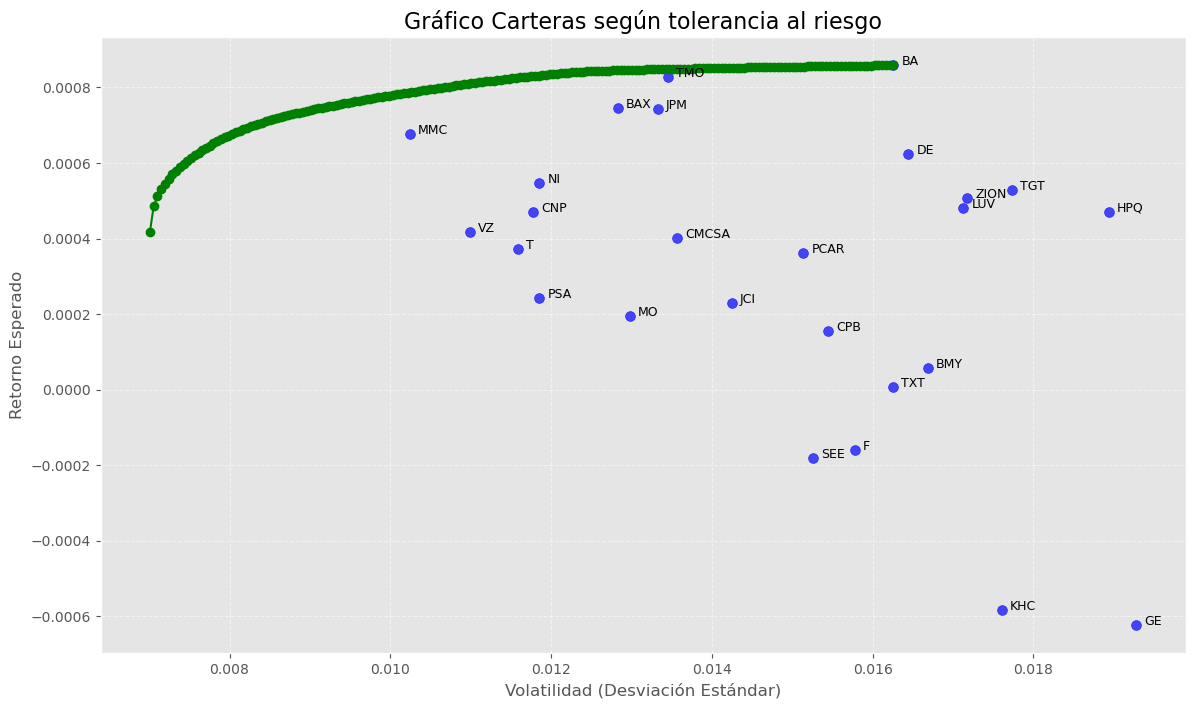

In [8]:
# Estableciendo un tamaño y estilo para el gráfico
plt.figure(figsize=(14, 8))
plt.style.use('ggplot')

# Puntos de cada activo
plt.scatter(np.sqrt(np.diag(matriz_cov)), retornos_esperados, color='blue', s=50, label='Activos', alpha=0.7)

# Añadiendo los nombres de los activos con un desplazamiento
desplazamiento_x = 0.0001  # Ajusta este valor según sea necesario
desplazamiento_y = 0.00002  # Ajusta este valor según sea necesario

for i, asset in enumerate(assets):
    plt.text(np.sqrt(matriz_cov[i, i]) + desplazamiento_x, retornos_esperados[i] , asset, fontsize=9)

plt.plot(riesgos_res, retornos_res, '-o', color='green')#,  alpha=0.3)   

# Añadiendo títulos y etiquetas
plt.title('Gráfico Carteras según tolerancia al riesgo', fontsize=16)
plt.xlabel('Volatilidad (Desviación Estándar)', fontsize=12)
plt.ylabel('Retorno Esperado', fontsize=12)

# Añadiendo leyenda con mejor posición
#plt.legend(loc='best')

# Mostrando la cuadrícula para mejor lectura
plt.grid(True, linestyle='--', alpha=0.5)

# Mostrar el gráfico
plt.show()


## 1. Carteras con posiciones cortas

### Carteras con posiciones cortas pero con límite de apalancamiento

El objetivo es calcular la cartera de máxima rentabilidad con un máximo en posiciones cortas, es decir, definiendo un límite máximo de apalancamiento (posición corta máxima). Primero, veamos las rentabilidades de cada uno de los activos:

In [ ]:
plt.figure(figsize=(15, 4))

plt.bar(range(len(retornos_esperados)), retornos_esperados, color='blue', alpha=0.7)

# Añadiendo los nombres de los activos como etiquetas en el eje x
plt.xticks(range(len(assets)), assets, rotation=45)

plt.title('Rentabilidad Esperada de los Activos', fontsize=16)

### Ejercicio 1

Como vemos, nuestra cartera dispone de activos que han tenido unos retornos esperados negativos. Si **nos ponemos en corto**, es decir, permitimos pesos negativos, al multiplicarlos por los activos con rentabilidad negativa, esto sumará al resultado final. Vamos a indicar que el límite de apalancamiento sea del `450%`, por tanto, la suma total de dinero invertido no debe superar el 500%.

In [ ]:
# TO DO

Vamos a pintar los pesos que ha calculado el optimizador permitiendo posiciones en corto junto a los rendimientos que hemos visto previamente:

In [ ]:
fig, ax = plt.subplots(figsize=(15, 4))

ax.bar(range(len(retornos_esperados)), retornos_esperados, color='blue', alpha=0.7)
ax2 = ax.twinx()
ax2.grid(False)
ax2.bar(range(num_act), pesos.value, width=0.5)

# Añadiendo los nombres de los activos como etiquetas en el eje x
ax.set_xticks(range(len(assets)), assets, rotation=45)
ax.set_yticks(np.linspace(-1e-3, 1e-3, 6), np.around(np.linspace(-1e-3, 1e-3, 6), decimals=4), color="blue")
ax2.set_yticks(np.linspace(-4.0, 4.0, 6), np.around(np.linspace(-4.0, 4.0, 6), decimals=4), color="red")

ax.set_title('Rentabilidad Esperada de los Activos y Pesos calculados', fontsize=16)

ax.set_ylim(-1e-3, 1e-3)
ax2.set_ylim(-4.0, 4.0)
plt.show()

Como se ve en la figura, al no restringir el riesgo de la cartera, el optimizador decide coger el activo con máxima rentabilidad positiva `BA` y lo combina con el que tiene máxima rentabilidad negativa `GE`.

In [ ]:
pesos_ajustados = np.array([np.round(x, 3) if np.abs(x) > 10**-4 else 0  for x in pesos.value])

activos_filtrados = [asset for i, asset in enumerate(assets) if pesos_ajustados[i] > 0]
pesos_filtrados = [x for x in pesos_ajustados if x != 0]

In [ ]:
print(f'Los activos que forman parte de la cartera son {np.array(assets)[pesos_ajustados != 0].tolist()}')

print(f'Los pesos que hacen que la cartera tenga el máximo retorno son: {pesos_ajustados[pesos_ajustados != 0].round(2)}')

print(f'Los retornos de los activos que forman parte de la cartera son: {retornos_esperados[pesos_ajustados != 0].round(4)}')

Vamos a ver dónde está la cartera que acabamos de generar:

In [ ]:
#Estableciendo un tamaño y estilo para el gráfico
plt.figure(figsize=(10, 6))

# Puntos de cada activo
plt.scatter(np.sqrt(np.diag(matriz_cov)), retornos_esperados, color='blue', s=50, alpha=0.7)


# Añadiendo los nombres de los activos con un desplazamiento
desplazamiento_x = 0.0001  # Ajusta este valor según sea necesario
desplazamiento_y = 0.00003  # Ajusta este valor según sea necesario

for i, asset in enumerate(assets):
    plt.text(np.sqrt(matriz_cov[i, i]) + desplazamiento_x, retornos_esperados[i] , asset, fontsize=9)



plt.scatter(np.sqrt(riesgo.value), resultado, color='red', s=100, marker='o')
plt.text(np.sqrt(riesgo.value) - 28*desplazamiento_x, resultado - desplazamiento_y, 'Cartera Calculada', fontsize=11, color='red')

plt.scatter(riesgos_res, retornos_res, color='green', s=20, marker='o')


# Añadiendo títulos y etiquetas
plt.title('Gráfico Carteras con posiciones cortas', fontsize=16)
plt.xlabel('Volatilidad (Desviación Estándar)', fontsize=12)
plt.ylabel('Retorno Esperado', fontsize=12)

# Añadiendo leyenda con mejor posición
#plt.legend(loc='best')

# Mostrando la cuadrícula para mejor lectura
plt.grid(True, linestyle='--', alpha=0.5)

# Mostrar el gráfico
plt.show()

---

### Cartera de *máxima rentabilidad según tolerancia al riesgo* variando el límite de endeudamiento en corto permitido

In [ ]:
cortas_max = [1.0, 1.3, 1.5, 1.7, 2.0] # Máximo apalancamiento permitido
resultados_df = pd.DataFrame()
num_sim = 100

In [ ]:
for deuda in cortas_max: #
    riesgos_res_short = np.zeros(num_sim) # Riesgos
    retornos_res_short = np.zeros(num_sim) # Retornos
    gamma_vals = np.logspace(-2, 3, num=num_sim) # Valores de gamma que es la adversión al riesgo

    for i in range(num_sim): 
        pesos = cp.Variable(num_act)
        gamma = cp.Parameter(nonneg=True)
        gamma.value = gamma_vals[i]
        
        ret = retornos_esperados.T @ pesos
        riesgo = cp.quad_form(pesos, matriz_cov)
        objetivo = cp.Maximize(ret - gamma * riesgo)

        constraints = [cp.sum(pesos) == 1,
                       cp.sum(cp.abs(pesos)) <= deuda]
        prob = cp.Problem(objetivo, constraints)
        prob.solve()

        # Verificar el estado del problema
        if prob.status not in ["infeasible", "unbounded"]:
            retornos_res_short[i] = ret.value
            riesgos_res_short[i] = cp.sqrt(riesgo).value
        else:
            print(f"Problema no resuelto para gamma={gamma.value}: {prob.status}")

    resultados_df[f'riesgo_{deuda}'] = riesgos_res_short
    resultados_df[f'retorno_{deuda}'] = retornos_res_short

In [ ]:
plt.figure(figsize=(10, 6))
plt.style.use('ggplot')

# Puntos de cada activo
plt.scatter(np.sqrt(np.diag(matriz_cov)), retornos_esperados, color='blue', s=50, alpha=0.7)

# Añadiendo los nombres de los activos con un desplazamiento
desplazamiento_x = 0.0001  # Ajusta este valor según sea necesario
desplazamiento_y = 0.00003  # Ajusta este valor según sea necesario

for i, asset in enumerate(assets):
    plt.text(np.sqrt(matriz_cov[i, i]) + desplazamiento_x, retornos_esperados[i] , asset, fontsize=9)

for deuda in cortas_max:
    plt.plot(resultados_df[f'riesgo_{deuda}'], resultados_df[f'retorno_{deuda}'], label=f'Límite pos. cortas: {deuda}')

plt.xlabel('Riesgo $\sigma$')
plt.ylabel('Retorno esperado $\mu$')
plt.title('Frontera Eficiente variando el límite de posiciones cortas')
plt.legend(loc='best')
plt.show()

---

### Ejercicio 2: 

Calcula la cartera de *máxima rentabilidad* limitando el riesgo `0.014` y la posición en corto máxima en un activo al `20%`.

In [ ]:
#TO-DO

In [ ]:
# Guardamos la cartera calculada para luego pintarla

max_cortos = np.array([np.sqrt(riesgo.value), ret.value])
max_cortos

In [ ]:
fig, ax = plt.subplots(figsize=(15, 4))

ax.bar(range(len(retornos_esperados)), retornos_esperados, color='blue', alpha=0.7)
ax2 = ax.twinx()
ax2.grid(False)
ax2.bar(range(num_act), pesos.value, width=0.5)

# Añadiendo los nombres de los activos como etiquetas en el eje x
ax.set_xticks(range(len(assets)), assets, rotation=45)
ax.set_yticks(np.linspace(-1e-3, 1e-3, 6), np.around(np.linspace(-1e-3, 1e-3, 6), decimals=4), color="blue")
ax.axhline(0.0, color="black")
ax2.set_yticks(np.linspace(-0.7, 0.7, 6), np.around(np.linspace(-0.7, 0.7, 6), decimals=4), color="red")
ax2.axhline(-0.2)

ax.set_title('Rentabilidad Esperada de los Activos y Pesos calculados', fontsize=16)

ax.set_ylim(-1e-3, 1e-3)
ax2.set_ylim(-0.7, 0.7)
plt.show()

Calculemos ahora la **cartera equivalente pero sin posiciones cortas** para poder compararlas.

In [ ]:
#TO-DO


In [ ]:
# Guardamos la cartera calculada para luego pintarla

max_sin_cortos = np.array([np.sqrt(riesgo.value), ret.value])
max_sin_cortos

In [ ]:
#ponemos los pesos a 0 si son muy pequeños (menores que 10**-4)

pesos_ajustados = np.array([np.round(x, 3) if np.abs(x) > 10**-4 else 0  for x in pesos.value])

activos_filtrados = [asset for i, asset in enumerate(assets) if pesos_ajustados[i] > 0]
pesos_filtrados = [x for x in pesos_ajustados if x != 0]

In [ ]:
print(f'Los activos que forman parte de la cartera son {np.array(assets)[pesos_ajustados != 0].tolist()}')

print(f'Los pesos que hacen que la cartera tenga el máximo retorno son: {pesos_ajustados[pesos_ajustados != 0].round(2)}')

In [ ]:
#Estableciendo un tamaño y estilo para el gráfico
plt.figure(figsize=(10, 6))
plt.style.use('ggplot')

# Puntos de cada activo
plt.scatter(np.sqrt(np.diag(matriz_cov)), retornos_esperados, color='blue', s=50, alpha=0.7)


# Añadiendo los nombres de los activos con un desplazamiento
desplazamiento_x = 0.0001  # Ajusta este valor según sea necesario
desplazamiento_y = 0.00003  # Ajusta este valor según sea necesario

for i, asset in enumerate(assets):
    plt.text(np.sqrt(matriz_cov[i, i]) + desplazamiento_x, retornos_esperados[i] , asset, fontsize=9)



plt.scatter(max_cortos[0], max_cortos[1], color='red', s=100, marker='o')
plt.text(max_cortos[0] + 2*desplazamiento_x, max_cortos[1] - desplazamiento_y, 'Cartera con cortos', fontsize=11, color='red')

plt.scatter(max_sin_cortos[0], max_sin_cortos[1], color='red', s=100, marker='o')
plt.text(max_sin_cortos[0] , max_sin_cortos[1] + 3 * desplazamiento_y, 'Cartera sin cortos', fontsize=11, color='red')

plt.scatter(riesgos_res, retornos_res, color='green', s=20, marker='o')


# Añadiendo títulos y etiquetas
plt.title('Gráfico Cartera limitando riesgo y posición corta en un solo activo', fontsize=16)
plt.xlabel('Volatilidad (Desviación Estándar)', fontsize=12)
plt.ylabel('Retorno Esperado', fontsize=12)

# Añadiendo leyenda con mejor posición
#plt.legend(loc='best')

# Mostrando la cuadrícula para mejor lectura
plt.grid(True, linestyle='--', alpha=0.5)

# Mostrar el gráfico
plt.show()